In [1]:
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/desert/desert_workspace/final_data.csv')
df=df.drop('Unnamed: 0', axis=1)
df.head()


,County,percent_food_desert,pop2010_in_des,num_tracts,n_food_des,n_urban,n_rural,urban_des,rural_des,Rural,...,Trichinosis,Tuberculosis,Tularemia,"Typhoid Fever, case",Typhus Fever,Varicella Hospitalizations,Vibrio Infection (non-Cholera),Yersiniosis,Cnty_Fips,opiods_rx_1000
0,Alameda,0.037134,56082.0,360.0,15.0,354.0,6.0,15.0,0.0,0.016667,...,0.0,12.354,0.000,0.727,0.0,0.132,0.528,0.264,1,557.20
1,Alpine,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,...,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,3,578.68
2,Amador,0.000000,0.0,9.0,0.0,0.0,9.0,0.0,0.0,1.000000,...,0.0,2.641,0.000,0.000,0.0,0.000,0.000,0.000,5,1244.76
3,Butte,0.268086,58979.0,51.0,14.0,38.0,13.0,13.0,1.0,0.254902,...,0.0,0.909,0.455,0.000,0.0,0.455,0.000,0.000,7,1389.20
4,Calaveras,0.000000,0.0,10.0,0.0,2.0,8.0,0.0,0.0,0.800000,...,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,9,1068.98


In [4]:
df.columns.tolist()
df['y'] = df['percent_food_desert'] >= .1
df['y'] =df['y'].astype(int)

In [5]:
from pymc import rbeta


class Discharges(object):

    """
    This class represents N discharge dispositions.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        dc( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def dc(self, i):
        # i is which arm to dc
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        discharges: a Discharges class with .dc method
    
    methods:
        sample_discharges(n): sample and train on n dc.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, discharges):

        self.discharges = discharges
        n_discharges = len(self.discharges)
        self.wins = np.zeros(n_discharges)
        self.trials = np.zeros(n_discharges)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_discharges(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the discharges's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen discharge
            result = self.discharges.dc(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [6]:
from IPython.core.pylabtools import figsize
import scipy.stats as stats

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d Discharges" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

In [7]:
df.columns.tolist()

['County',
 'percent_food_desert',
 'pop2010_in_des',
 'num_tracts',
 'n_food_des',
 'n_urban',
 'n_rural',
 'urban_des',
 'rural_des',
 'Rural',
 'Urban',
 'LILATracts_1And10',
 'high_food_des_prev',
 'cnty_obesity_pct',
 'cnty_obesity_pct_adj',
 'cnty_dm_pct',
 'cnty_dm_pct_adj',
 'cnty_inactive_pct',
 'cnty_inactive_pct_adj',
 'POP2010',
 'OHU2010',
 'NUMGQTRS',
 'HUNVFlag',
 'Adolescent_births',
 'ABR',
 'p_hs_edatt',
 'PC_PHYS_R',
 'DENTIST_R',
 'PSYCH_R',
 'PCT_HSPNC',
 'PCT_WHITE',
 'PCT_BLACK',
 'PCT_ASIAN',
 'PCT_AMIND_ESK',
 'PCT_ISLANDER',
 'PCT_MULTI',
 'PCT_OTHER',
 'PCT_65OVER',
 'PCT_18_64',
 'PCT_UNDR18',
 'PCT_UNDER5',
 'des_percent',
 'unemployment_rate',
 'n_hospitals',
 'mort_30_ami',
 'mort_30_cabg',
 'mort_30_copd',
 'mort_30_hf',
 'mort_30_pn',
 'mort_30_stk',
 'readm_30_ami',
 'readm_30_cabg',
 'readm_30_copd',
 'readm_30_hf',
 'readm_30_hip_knee',
 'readm_30_hosp_wide',
 'readm_30_pn',
 'readm_30_stk',
 'Amebiasis',
 'Anaplasmosis and Ehrlichiosis',
 'Babesiosi

In [8]:
bayes = df[['County', 'num_tracts','n_urban','n_food_des']]
#bayes
df.columns.tolist()
bayes['food_des_perc'] = bayes['n_food_des'] / bayes['num_tracts']
bayes

/Users/desert/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,County,num_tracts,n_urban,n_food_des,food_des_perc
0,Alameda,360.0,354.0,15.0,0.041667
1,Alpine,1.0,0.0,0.0,0.000000
2,Amador,9.0,0.0,0.0,0.000000
3,Butte,51.0,38.0,14.0,0.274510
4,Calaveras,10.0,2.0,0.0,0.000000
5,Colusa,5.0,2.0,1.0,0.200000
6,Contra Costa,208.0,202.0,15.0,0.072115
7,Del Norte,7.0,4.0,3.0,0.428571
8,El Dorado,43.0,20.0,3.0,0.069767
9,Fresno,199.0,170.0,31.0,0.155779


In [9]:
bayes['urban_perc'] = bayes['n_urban'] / bayes['num_tracts']
bayes
bayes['more_urban'] = bayes['urban_perc'] > .5
bayes = bayes.groupby('more_urban').agg(np.mean)

/Users/desert/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/desert/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
bayes

,num_tracts,n_urban,n_food_des,food_des_perc,urban_perc
more_urban,,,,,
False,10.904762,3.666667,1.714286,0.178579,0.253032
True,211.216216,196.891892,13.540541,0.121497,0.830593


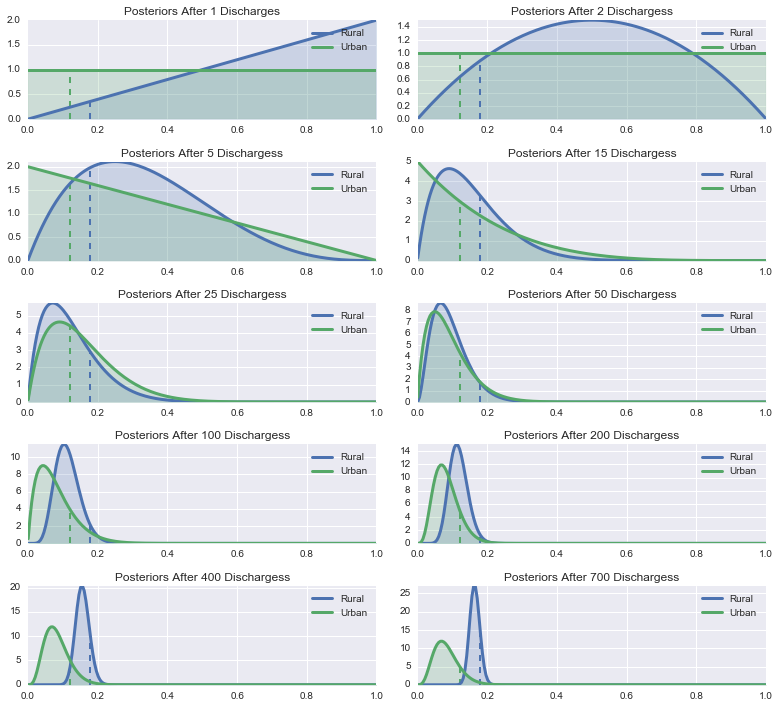

In [11]:
hidden_prob = bayes['food_des_perc'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 300]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['Rural','Urban'])#['home','rehab','LTC','nursing','psych']

    #plt.legend(labels=['home','SNF','home_health','AMA','hospice','psych'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()

In [ ]:
from pymc import rbeta


class Bandits(object):

    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [ ]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

In [ ]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]
draw_samples = [1, 1, 3, 10]#, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    print bayesian_strat.choices
    print bayesian_strat.bb_score
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()

In [ ]:
beta

In [ ]:
figsize(12.5, 5)
from other_strats import *

# define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

# define regret


def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# create new strategies
strategies = [upper_credible_choice,
              bayesian_bandit_choice,
              ucb_bayes,
              max_mean,
              random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

In [ ]:
# train 10000 times
for strat in algos:
    strat.sample_bandits(10000)

#test and plot
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc="upper left");

In [ ]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1, 13, size=35)
print hidden_prob
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j, i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=2, alpha=0.0, plt_vlines=False)
    # plt.legend()
    plt.xlim(0, 0.5)

In [ ]:
hidden_prob

In [ ]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL": (0.05, 0.03),
                       "GOOG": (-0.03, 0.04),
                       "TSLA": (-0.02, 0.01),
                       "AMZN": (0.03, 0.02),
                       }
expert_prior_params.items()
for i, (name, params) in enumerate(expert_prior_params.iteritems()):
    #plt.subplot(2, 2)#, expert_prior_params[i])
    y = normal.pdf(x, params[0], scale=params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color=colors[i], linewidth=2,
                     edgecolor=colors[i], alpha=0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k", "--", linewidth=0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

In [ ]:
import pymc as pm

n_observations = 100  # we will truncate the the most recent 100 days.

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, np.diag(prior_std ** 2))
mu = pm.Normal("returns", prior_mu, 1, size=4)

In [ ]:
import datetime
import ystockquote as ysq

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = datetime.datetime.now().strftime("%Y-%m-%d")  # today's date.
startdate = "2012-09-01"

stock_closes = {}
stock_returns = {}
CLOSE = 6

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_closes[stock] = x[1:, CLOSE].astype(float)

# create returns:

for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day) / _previous_day)[:n_observations]

dates = map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations + 1, 0])

In [ ]:
figsize(12.5, 4)

for _stock, _returns in stock_returns.iteritems():
    p = plt.plot((1 + _returns)[::-1].cumprod() - 1, '-o', label="%s" % _stock,
                 markersize=4, markeredgecolor="none")

plt.xticks(np.arange(100)[::-8],
           map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8]),
           rotation=60);

plt.legend(loc="upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

In [ ]:
figsize(11., 5)
returns = np.zeros((n_observations, 4))

for i, (_stock, _returns) in enumerate(stock_returns.iteritems()):
    returns[:, i] = _returns
    #plt.subplot(2, 2, i)
    plt.hist(_returns, bins=20,
             normed=True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    #plt.title(_stock + " returns")
    plt.legend()
    plt.xlim(-0.15, 0.15)

plt.tight_layout()

plt.suptitle("Histogram of daily returns", size=14);


In [ ]:
obs = pm.MvNormal("observed returns", mu, inv_cov_matrix, observed=True, value=returns)

model = pm.Model([obs, mu, inv_cov_matrix])
mcmc = pm.MCMC()

mcmc.sample(150000, 100000, 3)

In [ ]:
figsize(12.5, 4)

# examine the mean return first.
mu_samples = mcmc.trace("returns")[:]

for i in range(4):
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True,
             label="%s" % stock_returns.keys()[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth=.5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

In [ ]:
figsize(11.0, 3)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True, color=colors[i],
             label="%s" % stock_returns.keys()[i])
    plt.title("%s" % stock_returns.keys()[i])
    plt.xlim(-0.15, 0.15)

plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

In [ ]:

inv_cov_samples = mcmc.trace("inv_cov_matrix")[:]
mean_covariance_matrix = np.linalg.inv(inv_cov_samples.mean(axis=0))


def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T / d).T) / d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1, 2, 1)
plt.imshow(cov2corr(mean_covariance_matrix), interpolation="none",
           cmap=plt.cm.hot)
plt.xticks(np.arange(4), stock_returns.keys())
plt.yticks(np.arange(4), stock_returns.keys())
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1, 2, 2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color="#348ABD", alpha=0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.keys());
plt.title("(mean posterior) variances of daily stock returns")

plt.tight_layout();

In [ ]:
df.head()
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

data = order(df,['LILATracts_1And10','num_tracts']).values
plt.scatter(data[:, 1], data[:, 0], alpha=0.5, c="#7A68A6")
plt.title("Food desert prev vs N Tracts")
plt.ylabel("Food desert prev")
plt.xlabel("number of tracts")
#plt.xlim(-100, 15e3)
#plt.ylim(-5, 105)

i_min = np.argmin(data[:, 0])
i_max = np.argmax(data[:, 0])

plt.scatter([data[i_min, 1], data[i_max, 1]],
            [data[i_min, 0], data[i_max, 0]],
            s=60, marker="o", facecolors="none",
            edgecolors="#A60628", linewidths=1.5,
            label="most extreme points")

plt.legend(scatterpoints=1);

In [ ]:
#upvotes = n_food_deserts
#downvotes = n_food_deserts - num_tracts
upvotes = df['n_food_des'].values
downvotes = df['num_tracts'].values -df['n_food_des'].values 
downvotes

def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
    """
    This function accepts the number of upvotes and downvotes a particular comment received, 
    and the number of posterior samples to return to the user. Assumes a uniform prior.
    """
    N = upvotes + downvotes
    upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
    observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
    # do the fitting; first do a MAP as it is cheap and useful.
    map_ = pm.MAP([upvote_ratio, observations]).fit()
    mcmc = pm.MCMC([upvote_ratio, observations])
    mcmc.sample(samples, samples / 4)
    return mcmc.trace("upvote_ratio")[:]

posterior_upvote_ratio(upvotes, downvotes, samples=20000)

In [ ]:
data = df[['n_food_des','num_tracts','County']].values
figsize(11., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"] * 12
colours
for i in range(len(data)):
    j = data[i]
    #print j
    posteriors.append(posterior_upvote_ratio(j[0], j[1]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.9,
             histtype="step", color=colours[i % 5], lw=3,
             label='(%d deserts:%d tracts)\n%s...' % (j[0], j[1], j[2]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.2,
             histtype="stepfilled", color=colours[i], lw=3, )
#     plt.legend(loc="upper left")
#     plt.xlim(0, 1)
#     plt.title("Posterior distributions of food desert ratios on different counties");
#     plt.show()

#plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.title("Posterior distributions of food desert ratios on different counties");

In [ ]:
y = df['percent_food_desert']
X = df['unemployment_rate']
linear_regression = smf.ols(formula='percent_food_desert ~ unemployment_rate', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()
betas = np.array(fitted_model.params)
fitted_values = fitted_model.predict()
df.plot(kind='scatter', x='unemployment_rate', y='percent_food_desert')
plt.plot(pd.DataFrame(df['unemployment_rate']),fitted_values,c='red',linewidth=2)

#ls_coef_ = np.cov(X,Y)[0,1]/np.var(X)

In [ ]:
# NOTE: the linear regression model we're trying to solve for is 
# given by:
# y = b0 + b1(x) + error
# where b0 is the intercept term, b1 is the slope, and error is 
# the error

# model the intercept/slope terms of our model as 
# normal random variables with comically large variances
b0 = pm.Normal("b0", 0, 0.0003)
b1 = pm.Normal("b1", 0, 0.0003)

# model our error term as a uniform random variable
err = pm.Uniform("err", 0, 500)


# "model" the observed x values as a normal random variable
# in reality, because x is observed, it doesn't actually matter
# how we choose to model x -- PyMC isn't going to change x's values
x_weight = pm.Normal("weight", 0, 1, value=np.array(df["unemployment_rate"]), observed=True)

# this is the heart of our model: given our b0, b1 and our x observations, we want
# to predict y
@pm.deterministic
def pred(b0=b0, b1=b1, x=x_weight):
    return b0 + b1*x

# "model" the observed y values: again, I reiterate that PyMC treats y as 
# evidence -- as fixed; it's going to use this as evidence in updating our belief
# about the "unobserved" parameters (b0, b1, and err), which are the 
# things we're interested in inferring after all
y = pm.Normal("y", pred, err, value=np.array(df["percent_food_desert"]), observed=True)

# put everything we've modeled into a PyMC model
model = pm.Model([pred, b0, b1, y, err, x_weight])

In [ ]:
# prepare for MCMC
mcmc = pm.MCMC(model)

# sample from our posterior distribution 50,000 times, but
# throw the first 20,000 samples out to ensure that we're only
# sampling from our steady-state posterior distribution
mcmc.sample(50000, 20000)

In [ ]:
print np.mean(mcmc.trace('b1')[:])
print np.mean(mcmc.trace('b0')[:])
plt.plot(mcmc.trace('b0')[:],mcmc.trace('b0')[:])
#plt.hist(mcmc.trace('b1')[:], bins=50)
xp = np.array([x.min(), x.max()])
plt.plot(a.trace()*xp[:, None] + b.trace(), c='red', alpha=0.01)
plt.plot(xp, np.mean(mcmc.trace('b1')[:])*xp + np.mean(mcmc.trace('b0')[:]), linewidth=2, c='red');

In [ ]:
mcmc.trace('b1')

In [ ]:
abar = a.stats()['mean']
bbar = b.stats()['mean']
# data.plot(x='x', y='y', kind='scatter', s=50);
# xp = np.array([x.min(), x.max()])
# plt.plot(a.trace()*xp[:, None] + b.trace(), c='red', alpha=0.01)
# plt.plot(xp, abar*xp + bbar, linewidth=2, c='red');

In [ ]:
@pm.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b

# observed data
n = 21
a = 6
b = 2
sigma = 2
x = np.linspace(0, 1, n)
y_obs = a*x + b + np.random.normal(0, sigma, n)
data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])

data.plot(x='x', y='y', kind='scatter', s=50);

# define priors
a = pm.Normal('slope', mu=0, tau=1.0/10**2)
b = pm.Normal('intercept', mu=0, tau=1.0/10**2)
tau = pm.Gamma("tau", alpha=0.1, beta=0.1)

# define likelihood
@pm.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b

y = pm.Normal('y', mu=mu, tau=tau, value=y_obs, observed=True)

# inference
m = pm.Model([a, b, tau, x, y])
mc = pm.MCMC(m)
mc.sample(iter=11000, burn=10000)



In [ ]:
# std = pm.Uniform('std', 0,100,trace=False)
# @pm.deterministic
# def prec(U=std):
#     return 1.0/U**2

# beta = pm.Poisson('beta', 0, 0.0001)
# alpha = pm.Poisson('alpha', 0, 0.0001)

# @pm.deterministic
# def mean(X=X, alpha=alpha, beta=beta):
#     return alpha + beta * X

# obs = pm.Normal('obs', mean,prec, value=Y, observed=True)
# mcmc.sample(100000,80000);
# define priors
a = pm.Normal('slope', mu=0, tau=1.0/10**2)
b = pm.Normal('intercept', mu=0, tau=1.0/10**2)
tau = pm.Gamma("tau", alpha=0.1, beta=0.1)
abar = a.stats()['mean']
bbar = b.stats()['mean']
data.plot(x='x', y='y', kind='scatter', s=50);
xp = np.array([x.min(), x.max()])
plt.plot(a.trace()*xp[:, None] + b.trace(), c='red', alpha=0.01)
plt.plot(xp, abar*xp + bbar, linewidth=2, c='red');

In [ ]:
data.describe()

In [ ]:
data
data = df[['unemployment_rate','percent_food_desert']]
#X = df['unemployment_rate']
data.describe()
y_obs=df['percent_food_desert']

In [ ]:
@pm.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b

# # observed data
n = 58
# a = 6
# b = 2
# sigma = 2
# x = np.linspace(0, 1, n)
# y_obs = a*x + b + np.random.normal(0, sigma, n)
# data = pd.DataFrame(np.array([x, y_obs]).T, columns=['x', 'y'])

# data.plot(x='x', y='y', kind='scatter', s=50);

# define priors
a = pm.Normal('slope', mu=0, tau=1.0/10**2)
b = pm.Normal('intercept', mu=0, tau=1.0/10**2)
tau = pm.Gamma("tau", alpha=0.1, beta=0.1)

# define likelihood
@pm.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b

y = pm.Normal('y', mu=mu, tau=tau, value=y_obs, observed=True)

# inference
m = pm.Model([a, b, tau, x, y])
mc = pm.MCMC(m)
mc.sample(iter=11000, burn=10000)